In [2]:
# !nvcc --version

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# !nvidia-smi

**DOWNLOAD & LOAD THE DATASET**

In [5]:
!pip install -q kaggle

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashfaaqahamed","key":"86e89dc41b42ce98d2ce0e2198cec3e2"}'}

In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/ 
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download -d wwwwwee/dehaze

 99% 1.77G/1.78G [00:16<00:00, 171MB/s]
100% 1.78G/1.78G [00:16<00:00, 114MB/s]


In [9]:
! unzip dehaze.zip

Streaming output truncated to the last 5000 lines.
  inflating: haze/0698_0.85_0.16.jpg  
  inflating: haze/0698_0.85_0.2.jpg  
  inflating: haze/0698_0.8_0.04.jpg  
  inflating: haze/0698_0.8_0.06.jpg  
  inflating: haze/0698_0.8_0.08.jpg  
  inflating: haze/0698_0.8_0.1.jpg   
  inflating: haze/0698_0.8_0.12.jpg  
  inflating: haze/0698_0.8_0.16.jpg  
  inflating: haze/0698_0.8_0.2.jpg   
  inflating: haze/0698_0.95_0.04.jpg  
  inflating: haze/0698_0.95_0.06.jpg  
  inflating: haze/0698_0.95_0.08.jpg  
  inflating: haze/0698_0.95_0.1.jpg  
  inflating: haze/0698_0.95_0.12.jpg  
  inflating: haze/0698_0.95_0.16.jpg  
  inflating: haze/0698_0.95_0.2.jpg  
  inflating: haze/0698_0.9_0.04.jpg  
  inflating: haze/0698_0.9_0.06.jpg  
  inflating: haze/0698_0.9_0.08.jpg  
  inflating: haze/0698_0.9_0.1.jpg   
  inflating: haze/0698_0.9_0.12.jpg  
  inflating: haze/0698_0.9_0.16.jpg  
  inflating: haze/0698_0.9_0.2.jpg   
  inflating: haze/0698_1_0.04.jpg    
  inflating: haze/0698_1_0.06.j

In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

Create new directories for the training and validation sets:

In [11]:
import os

base_dir = '/content'
train_hazy_dir = os.path.join(base_dir, 'train/hazy')
train_clear_dir = os.path.join(base_dir, 'train/clear')
val_hazy_dir = os.path.join(base_dir, 'val/hazy')
val_clear_dir = os.path.join(base_dir, 'val/clear')

os.makedirs(train_hazy_dir, exist_ok=True)
os.makedirs(train_clear_dir, exist_ok=True)
os.makedirs(val_hazy_dir, exist_ok=True)
os.makedirs(val_clear_dir, exist_ok=True)

Split the original dataset into training and validation sets:

In [12]:
import shutil
from sklearn.model_selection import train_test_split

hazy_dir = os.path.join(base_dir, 'haze')
clear_dir = os.path.join(base_dir, 'clear_images')
hazy_files = sorted(os.listdir(hazy_dir))
clear_files = sorted(os.listdir(clear_dir))

clear_train_files, clear_val_files = train_test_split(clear_files, test_size=0.2, random_state=42)

for clear_file in clear_files:
    clear_id = os.path.splitext(clear_file)[0]
    matched_hazy_files = [hazy_file for hazy_file in hazy_files if hazy_file.startswith(clear_id + '_')]
    
    if clear_file in clear_train_files:
        shutil.copy(os.path.join(clear_dir, clear_file), os.path.join(train_clear_dir, clear_file))
        for matched_hazy_file in matched_hazy_files:
            shutil.copy(os.path.join(hazy_dir, matched_hazy_file), os.path.join(train_hazy_dir, matched_hazy_file))
    else:
        shutil.copy(os.path.join(clear_dir, clear_file), os.path.join(val_clear_dir, clear_file))
        for matched_hazy_file in matched_hazy_files:
            shutil.copy(os.path.join(hazy_dir, matched_hazy_file), os.path.join(val_hazy_dir, matched_hazy_file))


In [13]:
def reside_data_generator(hazy_dir, clear_dir, batch_size, img_size, shuffle=True):
    hazy_files = sorted(os.listdir(hazy_dir))
    clear_files = sorted(os.listdir(clear_dir))

    file_mapping = []
    for clear_file in clear_files:
        clear_id = os.path.splitext(clear_file)[0]
        matched_hazy_files = [hazy_file for hazy_file in hazy_files if hazy_file.startswith(clear_id + '_')]
        for matched_hazy_file in matched_hazy_files:
            file_mapping.append((matched_hazy_file, clear_file))

    if shuffle:
        np.random.shuffle(file_mapping)

    while True:
        for i in range(0, len(file_mapping), batch_size):
            batch_files = file_mapping[i:i+batch_size]
            batch_hazy_imgs = []
            batch_clear_imgs = []

            for hazy_file, clear_file in batch_files:
                hazy_img = Image.open(os.path.join(hazy_dir, hazy_file)).resize(img_size)
                clear_img = Image.open(os.path.join(clear_dir, clear_file)).resize(img_size)

                hazy_img = np.array(hazy_img) / 127.5 - 1.0
                clear_img = np.array(clear_img) / 127.5 - 1.0

                batch_hazy_imgs.append(hazy_img)
                batch_clear_imgs.append(clear_img)

            yield np.array(batch_hazy_imgs), np.array(batch_clear_imgs)


In [14]:
batch_size = 16
img_size = (256, 256)

# train_gen = reside_data_generator("path/to/train/hazy", "path/to/train/clear", batch_size, img_size)
# val_gen = reside_data_generator("path/to/val/hazy", "path/to/val/clear", batch_size, img_size)
train_gen = reside_data_generator(train_hazy_dir, train_clear_dir, batch_size, img_size)
val_gen = reside_data_generator(val_hazy_dir, val_clear_dir, batch_size, img_size)


In [15]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.keras.optimizers import Adam 
from keras.initializers import RandomNormal


In [16]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-5xa7w3sj
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-5xa7w3sj
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101078 sha256=ccc8b17704a9edbaeecfc444eb51fd375534adfdf4233f7bc03d4ca8795585ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-h7ci97qq/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras-contrib


In [17]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Activation
from keras.layers import Concatenate


Generator and Discriminator architectures


In [18]:
from tensorflow import keras

def resisudal_block(filters, size):
  result = tf.keras.Sequential()
  result.add(downsample(filters, size, strides=1, activation='ReLU'))
  result.add(downsample(filters, size, strides=1, activation='None'))

  return result

def resnet_block(n_filters, input_layer):
    init = RandomNormal(stddev=0.02, mean=0.0)
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Concatenate()([g, input_layer])
    return g

import tensorflow as tf
from tensorflow.keras.layers import Conv2D , Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam    
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()  
from tensorflow.keras.layers import Multiply, Add

def build_generator(n_resnet=9):
    inputs = tf.keras.Input(shape = [256, 256, 3])     # height, width of input image changed because of error in output
    
    init = RandomNormal(stddev=0.02,mean=0.0)
    
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(inputs)
    g = InstanceNormalization(axis=-1)(g)
    g = tf.keras.layers.Activation('relu')(g)
    
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = tf.keras.layers.Activation('relu')(g)
    
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = tf.keras.layers.Activation('relu')(g)

    g = Conv2D(512, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = tf.keras.layers.Activation('relu')(g) 
    
    # g = Conv2D(512, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    # g = InstanceNormalization(axis=-1)(g)
    # g = tf.keras.layers.Activation('relu')(g)

    for _ in range(n_resnet):
        g = resnet_block(256, g)
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)


    conv4_1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(g)
    conv4_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_1)
    conv4_3 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_2)
    conv4_4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_3)
    conv4_5 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_4)
    conc4 = tf.add(conv4_5, conv4_1)
    conv4 = tf.keras.activations.relu(conc4)
    
                                            ##### Decoding Layers #####
    deconv = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                             kernel_regularizer = regularizer)(conv4)
    deconv = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                             kernel_regularizer = regularizer)(deconv)

    conv = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(deconv)
    conv = tf.keras.layers.Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                  bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    conc = tf.add(conv, inputs)
    
    # output = tf.keras.activations.relu(conc)

    outputs = tf.keras.layers.experimental.preprocessing.Resizing(256, 256, interpolation='bilinear')(conc)
    
    return Model(inputs = inputs, outputs = outputs)


def downsample(filters, size, apply_batchnorm=True, strides=2, padding='same', activation='LeakyReLU'):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=strides, padding=padding,
                             use_bias=True))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  if activation == 'ReLU':
    result.add(tf.keras.layers.ReLU())
  elif activation == 'LeakyReLU':
    result.add(tf.keras.layers.LeakyReLU())

  return result


def build_discriminator():
    input_hazy = tf.keras.layers.Input(shape=(256, 256, 3))
    input_clear = tf.keras.layers.Input(shape=(256, 256, 3))

    # Concatenate the feature maps from the ResNet backbone
    inp = tf.keras.layers.concatenate([input_hazy, input_clear])
    init = RandomNormal(stddev=0.02, mean=0.0)
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inp)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)

    return tf.keras.Model(inputs=[input_hazy, input_clear], outputs=patch_out)

Create the generator and discriminator models and Define the GAN model, loss functions, and optimizers:

In [19]:
def build_combined_model(generator, discriminator):
    hazy_input = tf.keras.layers.Input(shape=(256, 256, 3))
    generated_image = generator(hazy_input)
    
    resized_hazy_input = tf.keras.layers.experimental.preprocessing.Resizing(256, 256, interpolation='bilinear')(hazy_input)
    resized_generated_image = tf.keras.layers.experimental.preprocessing.Resizing(256, 256, interpolation='bilinear')(generated_image)
    
    discriminator.trainable = False
    discriminator_output = discriminator([resized_hazy_input, resized_generated_image])

    return tf.keras.Model(inputs=hazy_input, outputs=[generated_image, discriminator_output])


generator = build_generator()
discriminator = build_discriminator()


loss_object = tf.keras.losses.MeanSquaredError()
l1_loss_object = tf.keras.losses.MeanAbsoluteError()


combined_model = build_combined_model(generator, discriminator)
combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
                       loss=[l1_loss_object, loss_object],
                       loss_weights=[100, 1])

discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
                      loss=loss_object)

discriminator.summary()


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_9 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

Implement the training loop. The training loop should include steps for training the discriminator and the generator:

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

def train_gan(train_gen, val_gen, num_epochs, steps_per_epoch, checkpoint_frequency=5):
    checkpoint_dir = './checkpoints'
    drive_dir = '/content/drive/My Drive/DehazeModels/TrainedOutdoor'
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    graph_disc_loss = []
    graph_gen_l1_loss = []
    graph_gen_adv_loss = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        epoch_disc_loss = []
        epoch_gen_l1_loss = []
        epoch_gen_adv_loss = []

        for step, (hazy_imgs, clear_imgs) in enumerate(train_gen):
            batch_size = hazy_imgs.shape[0]

            # Train the discriminator
            generated_imgs = generator.predict(hazy_imgs)
            real_labels = np.ones((batch_size, 16, 16, 1))
            fake_labels = np.zeros((batch_size,16, 16, 1))

            real_loss = discriminator.train_on_batch([hazy_imgs, clear_imgs], real_labels)
            fake_loss = discriminator.train_on_batch([hazy_imgs, generated_imgs], fake_labels)
            disc_loss = 0.5 * (real_loss + fake_loss)
            epoch_disc_loss.append(disc_loss)

            # Train the generator (using the combined model)
            valid_labels = np.ones((batch_size,16, 16, 1))
            combined_loss = combined_model.train_on_batch(hazy_imgs, [clear_imgs, valid_labels])
            epoch_gen_l1_loss.append(combined_loss[0])
            epoch_gen_adv_loss.append(combined_loss[1])

            if step >= steps_per_epoch - 1:
                break

        # Print epoch progress and any other metrics you'd like to track
        avg_disc_loss = np.mean(epoch_disc_loss)
        avg_gen_l1_loss = np.mean(epoch_gen_l1_loss)
        avg_gen_adv_loss = np.mean(epoch_gen_adv_loss)
        print(f"Discriminator loss: {avg_disc_loss:.4f}, Generator L1 loss: {avg_gen_l1_loss:.4f}, Generator adversarial loss: {avg_gen_adv_loss:.4f}")

        graph_disc_loss.append(avg_disc_loss)
        graph_gen_l1_loss.append(avg_gen_l1_loss)
        graph_gen_adv_loss.append(avg_gen_adv_loss)

        print("graph_disc_loss [] - ", graph_disc_loss)
        print("graph_gen_l1_loss [] - ", graph_gen_l1_loss)
        print("graph_gen_adv_loss [] - ", graph_gen_adv_loss)

        if (epoch + 1) % checkpoint_frequency == 0:

            # Plot the curves
            plt.plot(graph_disc_loss, 'r', label='Discriminator Loss')
            plt.plot(graph_gen_l1_loss, 'g', label='Generator L1 Loss')
            plt.plot(graph_gen_adv_loss, 'b', label='Generator Adversarial Loss')
            plt.legend()
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title(f'GAN Loss Curves (Epoch {epoch + 1})')
            plt.savefig(f'./loss_curves_epoch_{epoch + 1}.png')
            plt.show()

            # Save model weights at checkpoints
            checkpoint_path = os.path.join(checkpoint_dir, f'generator_{epoch + 1:04d}.h5')
            generator.save_weights(checkpoint_path)
            
            # Save model to drive
            drive_path = os.path.join(drive_dir, f'generator_{epoch + 1:04d}.h5')
            generator.save_weights(drive_path)

            print(f"Saved generator weights at {checkpoint_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Train the GAN using the generators:

Epoch 1/60
1/1 [==============================] - 0s 30ms/step
Discriminator loss: 1.7014, Generator L1 loss: 13.8083, Generator adversarial loss: 0.1175
graph_disc_loss [] -  [1.701395262258883]
graph_gen_l1_loss [] -  [13.808278071613739]
graph_gen_adv_loss [] -  [0.11753538674630296]
Epoch 2/60
1/1 [==============================] - 0s 32ms/step
Discriminator loss: 1.6247, Generator L1 loss: 10.3327, Generator adversarial loss: 0.0863
graph_disc_loss [] -  [1.701395262258883, 1.6246627257845272]
graph_gen_l1_loss [] -  [13.808278071613739, 10.332695418653397]
graph_gen_adv_loss [] -  [0.11753538674630296, 0.08634548379590336]
Epoch 3/60
1/1 [==============================] - 0s 31ms/step
Discriminator loss: 1.5929, Generator L1 loss: 9.0243, Generator adversarial loss: 0.0757
graph_disc_loss [] -  [1.701395262258883, 1.6246627257845272, 1.5929412718017262]
graph_gen_l1_loss [] -  [13.808278071613739, 10.332695418653397, 9.024314554354634]
graph_gen_adv_loss [] -  [0.1175353867463029

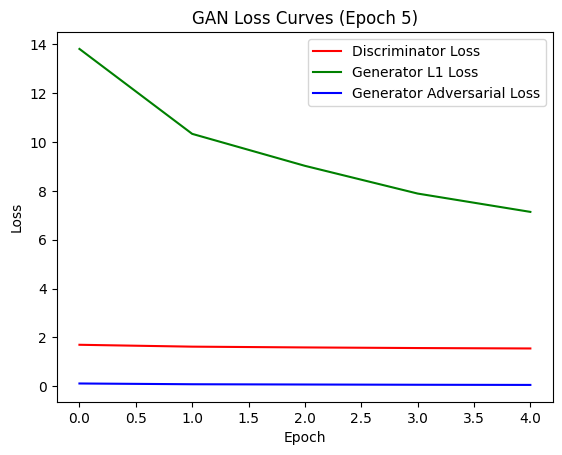

Saved generator weights at ./checkpoints/generator_0005.h5
Epoch 6/60
1/1 [==============================] - 0s 30ms/step
Discriminator loss: 1.5244, Generator L1 loss: 6.6827, Generator adversarial loss: 0.0548
graph_disc_loss [] -  [1.701395262258883, 1.6246627257845272, 1.5929412718017262, 1.5677257558217825, 1.5506488529447549, 1.5243965184536223]
graph_gen_l1_loss [] -  [13.808278071613739, 10.332695418653397, 9.024314554354634, 7.889697391765948, 7.139536696120192, 6.682672866236287]
graph_gen_adv_loss [] -  [0.11753538674630296, 0.08634548379590336, 0.07567972680345511, 0.06545125966826186, 0.05878310599408972, 0.05481462797132163]
Epoch 7/60
1/1 [==============================] - 0s 29ms/step
Discriminator loss: 1.5077, Generator L1 loss: 6.2779, Generator adversarial loss: 0.0514
graph_disc_loss [] -  [1.701395262258883, 1.6246627257845272, 1.5929412718017262, 1.5677257558217825, 1.5506488529447549, 1.5243965184536223, 1.5076777658904323]
graph_gen_l1_loss [] -  [13.8082780716

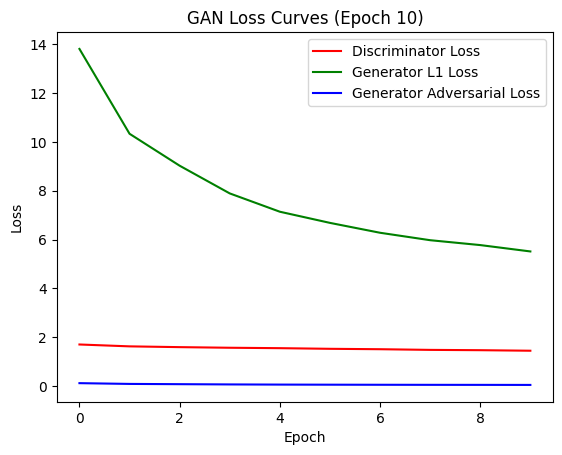

Saved generator weights at ./checkpoints/generator_0010.h5
Epoch 11/60
1/1 [==============================] - 0s 31ms/step
Discriminator loss: 1.4359, Generator L1 loss: 5.4049, Generator adversarial loss: 0.0446
graph_disc_loss [] -  [1.701395262258883, 1.6246627257845272, 1.5929412718017262, 1.5677257558217825, 1.5506488529447549, 1.5243965184536223, 1.5076777658904323, 1.4804108577033581, 1.4678138673019867, 1.4458457659513424, 1.4359443398615042]
graph_gen_l1_loss [] -  [13.808278071613739, 10.332695418653397, 9.024314554354634, 7.889697391765948, 7.139536696120192, 6.682672866236287, 6.277886404397008, 5.97304623728743, 5.773300248593949, 5.512637909228047, 5.404947753150623]
graph_gen_adv_loss [] -  [0.11753538674630296, 0.08634548379590336, 0.07567972680345511, 0.06545125966826186, 0.05878310599408972, 0.05481462797132163, 0.05143286769810957, 0.04886706331715036, 0.04744044460427647, 0.04523448719860266, 0.044585422847788936]
Epoch 12/60
1/1 [==============================] - 0

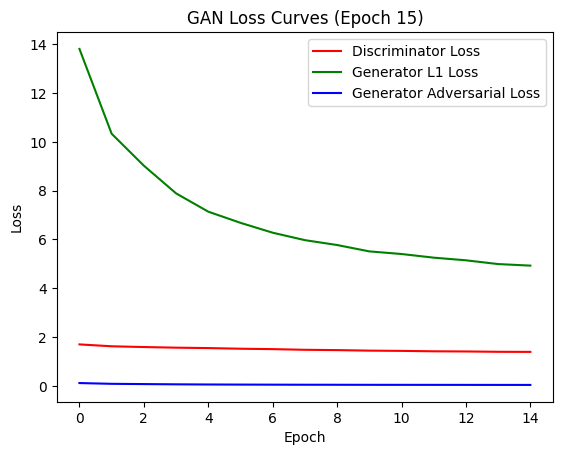

Saved generator weights at ./checkpoints/generator_0015.h5
Epoch 16/60
1/1 [==============================] - 0s 32ms/step
Discriminator loss: 1.3874, Generator L1 loss: 4.8149, Generator adversarial loss: 0.0404
graph_disc_loss [] -  [1.701395262258883, 1.6246627257845272, 1.5929412718017262, 1.5677257558217825, 1.5506488529447549, 1.5243965184536223, 1.5076777658904323, 1.4804108577033581, 1.4678138673019867, 1.4458457659513424, 1.4359443398615042, 1.4189474608856267, 1.4120609516057725, 1.398444150678647, 1.3950546987045307, 1.3873677124230626]
graph_gen_l1_loss [] -  [13.808278071613739, 10.332695418653397, 9.024314554354634, 7.889697391765948, 7.139536696120192, 6.682672866236287, 6.277886404397008, 5.97304623728743, 5.773300248593949, 5.512637909228047, 5.404947753150623, 5.255262606441023, 5.146910190582275, 4.992959762152772, 4.929493272647309, 4.814891864697392]
graph_gen_adv_loss [] -  [0.11753538674630296, 0.08634548379590336, 0.07567972680345511, 0.06545125966826186, 0.0587

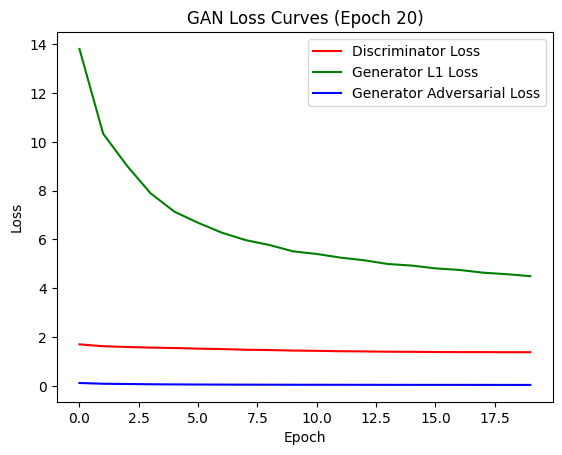

Saved generator weights at ./checkpoints/generator_0020.h5
Epoch 21/60
1/1 [==============================] - 0s 37ms/step
Discriminator loss: 1.3773, Generator L1 loss: 4.5284, Generator adversarial loss: 0.0388
graph_disc_loss [] -  [1.701395262258883, 1.6246627257845272, 1.5929412718017262, 1.5677257558217825, 1.5506488529447549, 1.5243965184536223, 1.5076777658904323, 1.4804108577033581, 1.4678138673019867, 1.4458457659513424, 1.4359443398615042, 1.4189474608856267, 1.4120609516057725, 1.398444150678647, 1.3950546987045307, 1.3873677124230626, 1.3836768877487213, 1.382763572679922, 1.3787181092241703, 1.3797373925439846, 1.3772981824775854]
graph_gen_l1_loss [] -  [13.808278071613739, 10.332695418653397, 9.024314554354634, 7.889697391765948, 7.139536696120192, 6.682672866236287, 6.277886404397008, 5.97304623728743, 5.773300248593949, 5.512637909228047, 5.404947753150623, 5.255262606441023, 5.146910190582275, 4.992959762152772, 4.929493272647309, 4.814891864697392, 4.752107088558209

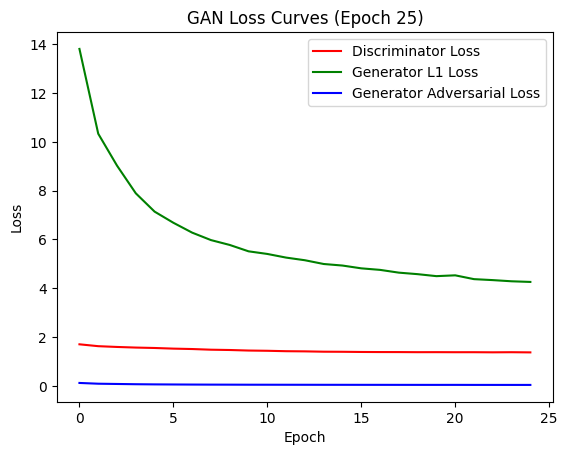

Saved generator weights at ./checkpoints/generator_0025.h5
Epoch 26/60
1/1 [==============================] - 0s 31ms/step
Discriminator loss: 1.3757, Generator L1 loss: 4.2198, Generator adversarial loss: 0.0365
graph_disc_loss [] -  [1.701395262258883, 1.6246627257845272, 1.5929412718017262, 1.5677257558217825, 1.5506488529447549, 1.5243965184536223, 1.5076777658904323, 1.4804108577033581, 1.4678138673019867, 1.4458457659513424, 1.4359443398615042, 1.4189474608856267, 1.4120609516057725, 1.398444150678647, 1.3950546987045307, 1.3873677124230626, 1.3836768877487213, 1.382763572679922, 1.3787181092241703, 1.3797373925439846, 1.3772981824775854, 1.3776847368802507, 1.3729002086784894, 1.377507709371396, 1.3703677408135355, 1.3757470856173732]
graph_gen_l1_loss [] -  [13.808278071613739, 10.332695418653397, 9.024314554354634, 7.889697391765948, 7.139536696120192, 6.682672866236287, 6.277886404397008, 5.97304623728743, 5.773300248593949, 5.512637909228047, 5.404947753150623, 5.25526260644

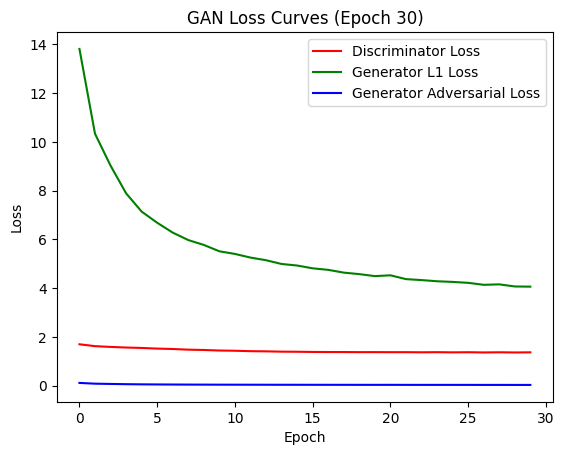

Saved generator weights at ./checkpoints/generator_0030.h5
Epoch 31/60
1/1 [==============================] - 0s 30ms/step
Discriminator loss: 1.3658, Generator L1 loss: 3.9897, Generator adversarial loss: 0.0347
graph_disc_loss [] -  [1.701395262258883, 1.6246627257845272, 1.5929412718017262, 1.5677257558217825, 1.5506488529447549, 1.5243965184536223, 1.5076777658904323, 1.4804108577033581, 1.4678138673019867, 1.4458457659513424, 1.4359443398615042, 1.4189474608856267, 1.4120609516057725, 1.398444150678647, 1.3950546987045307, 1.3873677124230626, 1.3836768877487213, 1.382763572679922, 1.3787181092241703, 1.3797373925439846, 1.3772981824775854, 1.3776847368802507, 1.3729002086784894, 1.377507709371396, 1.3703677408135355, 1.3757470856173732, 1.3662961014448263, 1.373105119544858, 1.3658748272413643, 1.3713084733524261, 1.365791658909557]
graph_gen_l1_loss [] -  [13.808278071613739, 10.332695418653397, 9.024314554354634, 7.889697391765948, 7.139536696120192, 6.682672866236287, 6.2778864

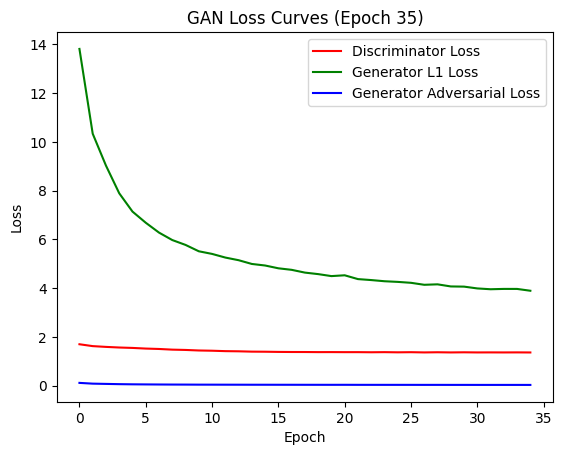

Saved generator weights at ./checkpoints/generator_0035.h5
Epoch 36/60
1/1 [==============================] - 0s 35ms/step
Discriminator loss: 1.3630, Generator L1 loss: 3.8111, Generator adversarial loss: 0.0332
graph_disc_loss [] -  [1.701395262258883, 1.6246627257845272, 1.5929412718017262, 1.5677257558217825, 1.5506488529447549, 1.5243965184536223, 1.5076777658904323, 1.4804108577033581, 1.4678138673019867, 1.4458457659513424, 1.4359443398615042, 1.4189474608856267, 1.4120609516057725, 1.398444150678647, 1.3950546987045307, 1.3873677124230626, 1.3836768877487213, 1.382763572679922, 1.3787181092241703, 1.3797373925439846, 1.3772981824775854, 1.3776847368802507, 1.3729002086784894, 1.377507709371396, 1.3703677408135355, 1.3757470856173732, 1.3662961014448263, 1.373105119544858, 1.3658748272413643, 1.3713084733524261, 1.365791658909557, 1.3673870907233545, 1.3656236812615166, 1.3678280591203, 1.3644996326857102, 1.3630193396212575]
graph_gen_l1_loss [] -  [13.808278071613739, 10.33269

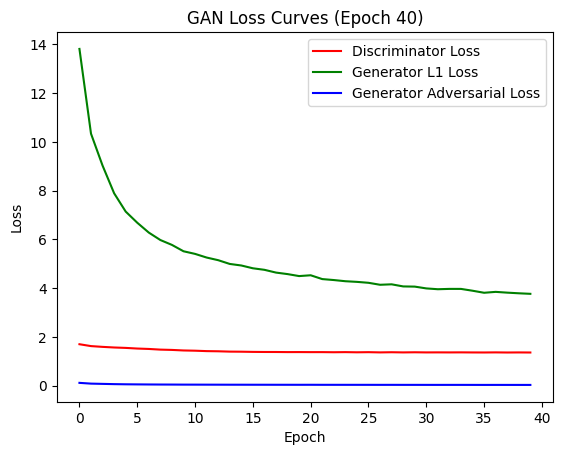

Saved generator weights at ./checkpoints/generator_0040.h5
Epoch 41/60
1/1 [==============================] - 0s 30ms/step
Discriminator loss: 1.3654, Generator L1 loss: 3.7781, Generator adversarial loss: 0.0332
graph_disc_loss [] -  [1.701395262258883, 1.6246627257845272, 1.5929412718017262, 1.5677257558217825, 1.5506488529447549, 1.5243965184536223, 1.5076777658904323, 1.4804108577033581, 1.4678138673019867, 1.4458457659513424, 1.4359443398615042, 1.4189474608856267, 1.4120609516057725, 1.398444150678647, 1.3950546987045307, 1.3873677124230626, 1.3836768877487213, 1.382763572679922, 1.3787181092241703, 1.3797373925439846, 1.3772981824775854, 1.3776847368802507, 1.3729002086784894, 1.377507709371396, 1.3703677408135355, 1.3757470856173732, 1.3662961014448263, 1.373105119544858, 1.3658748272413643, 1.3713084733524261, 1.365791658909557, 1.3673870907233545, 1.3656236812615166, 1.3678280591203, 1.3644996326857102, 1.3630193396212575, 1.3668473587630274, 1.3620546764363877, 1.36516630054

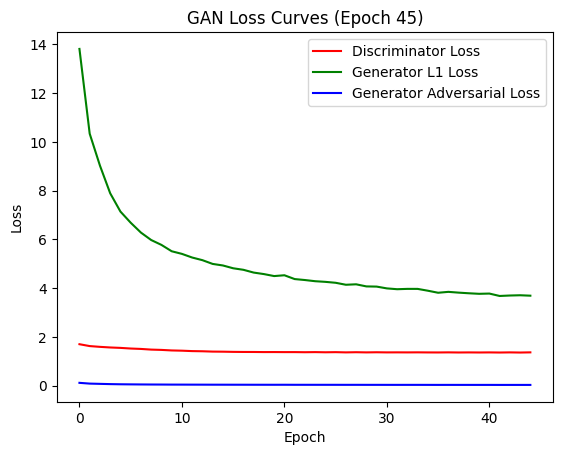

Saved generator weights at ./checkpoints/generator_0045.h5
Epoch 46/60
1/1 [==============================] - 0s 30ms/step
Discriminator loss: 1.3581, Generator L1 loss: 3.6143, Generator adversarial loss: 0.0317
graph_disc_loss [] -  [1.701395262258883, 1.6246627257845272, 1.5929412718017262, 1.5677257558217825, 1.5506488529447549, 1.5243965184536223, 1.5076777658904323, 1.4804108577033581, 1.4678138673019867, 1.4458457659513424, 1.4359443398615042, 1.4189474608856267, 1.4120609516057725, 1.398444150678647, 1.3950546987045307, 1.3873677124230626, 1.3836768877487213, 1.382763572679922, 1.3787181092241703, 1.3797373925439846, 1.3772981824775854, 1.3776847368802507, 1.3729002086784894, 1.377507709371396, 1.3703677408135355, 1.3757470856173732, 1.3662961014448263, 1.373105119544858, 1.3658748272413643, 1.3713084733524261, 1.365791658909557, 1.3673870907233545, 1.3656236812615166, 1.3678280591203, 1.3644996326857102, 1.3630193396212575, 1.3668473587630274, 1.3620546764363877, 1.36516630054

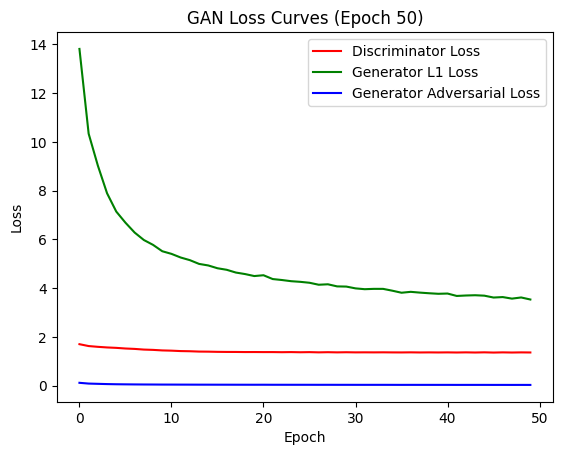

Saved generator weights at ./checkpoints/generator_0050.h5
Epoch 51/60
1/1 [==============================] - 0s 30ms/step
Discriminator loss: 1.3643, Generator L1 loss: 3.5658, Generator adversarial loss: 0.0315
graph_disc_loss [] -  [1.701395262258883, 1.6246627257845272, 1.5929412718017262, 1.5677257558217825, 1.5506488529447549, 1.5243965184536223, 1.5076777658904323, 1.4804108577033581, 1.4678138673019867, 1.4458457659513424, 1.4359443398615042, 1.4189474608856267, 1.4120609516057725, 1.398444150678647, 1.3950546987045307, 1.3873677124230626, 1.3836768877487213, 1.382763572679922, 1.3787181092241703, 1.3797373925439846, 1.3772981824775854, 1.3776847368802507, 1.3729002086784894, 1.377507709371396, 1.3703677408135355, 1.3757470856173732, 1.3662961014448263, 1.373105119544858, 1.3658748272413643, 1.3713084733524261, 1.365791658909557, 1.3673870907233545, 1.3656236812615166, 1.3678280591203, 1.3644996326857102, 1.3630193396212575, 1.3668473587630274, 1.3620546764363877, 1.36516630054

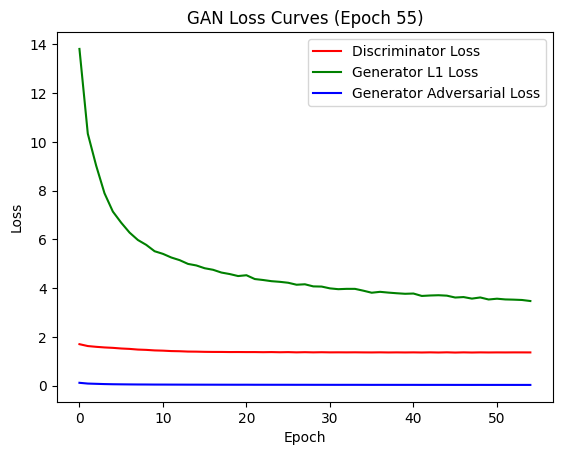

Saved generator weights at ./checkpoints/generator_0055.h5
Epoch 56/60
1/1 [==============================] - 0s 30ms/step
Discriminator loss: 1.3676, Generator L1 loss: 3.4558, Generator adversarial loss: 0.0307
graph_disc_loss [] -  [1.701395262258883, 1.6246627257845272, 1.5929412718017262, 1.5677257558217825, 1.5506488529447549, 1.5243965184536223, 1.5076777658904323, 1.4804108577033581, 1.4678138673019867, 1.4458457659513424, 1.4359443398615042, 1.4189474608856267, 1.4120609516057725, 1.398444150678647, 1.3950546987045307, 1.3873677124230626, 1.3836768877487213, 1.382763572679922, 1.3787181092241703, 1.3797373925439846, 1.3772981824775854, 1.3776847368802507, 1.3729002086784894, 1.377507709371396, 1.3703677408135355, 1.3757470856173732, 1.3662961014448263, 1.373105119544858, 1.3658748272413643, 1.3713084733524261, 1.365791658909557, 1.3673870907233545, 1.3656236812615166, 1.3678280591203, 1.3644996326857102, 1.3630193396212575, 1.3668473587630274, 1.3620546764363877, 1.36516630054

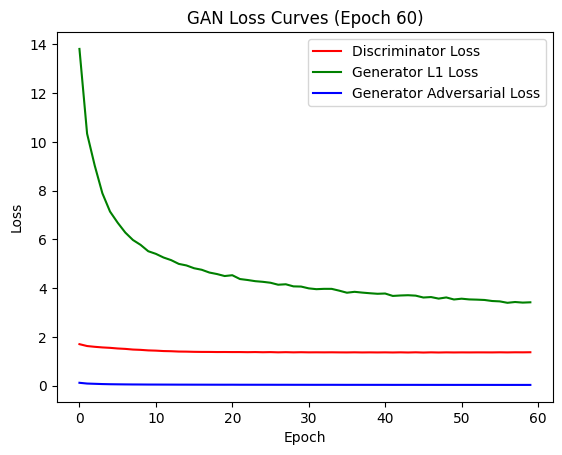

Saved generator weights at ./checkpoints/generator_0060.h5


In [ ]:
import math

num_epochs = 60
steps_per_epoch = math.ceil(10000 / 32)
train_gan(train_gen, val_gen, num_epochs, steps_per_epoch)

**EVALUATION**

In [29]:
import tensorflow as tf
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define custom objects for loading model
# custom_objects = {'tf': tf}

# Load saved model
# model_path = '/content/drive/My Drive/DehazeModels/generator_0010.h5'
# model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

weights_path = '/content/drive/My Drive/DehazeModels/TrainedOutdoor/generator_0060.h5'
# weights_path = '/content/checkpoints/generator_0005.h5'
# weights_path = '/content/generator_0100.h5'
generator.load_weights(weights_path)

# Define path to test image
# image_path = '/content/yasas.jpg'
# image_path = '/content/yasithaHazy.jpg'
# image_path = '/content/haze/0468_1_0.16.jpg'
image_path = '/content/haze/0469_0.85_0.2.jpg'
# image_path = '/content/drive/MyDrive/Test_Images/0471_0.95_0.2.jpg'
# image_path = '/content/drive/MyDrive/Test_Images/1000_10_0.74905.png'
# image_path = '/content/drive/MyDrive/Test_images/1000_1_0.99837.png'

# image_path = '/content/Input/1000_10_0.74905.png'

# Evaluate image using the loaded model
# evaluation(generator, image_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import datetime
import numpy as np
import tensorflow as tf
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

start_time = datetime.datetime.now()

# Load a hazy image
input_image_path = image_path
hazy_image = Image.open(input_image_path)

# Preprocess the hazy image
hazy_image = hazy_image.resize((256, 256))  # Resize the image to match the generator input size
hazy_image = np.array(hazy_image) / 127.5 - 1.0  # Scale pixel values to the range [-1, 1]
hazy_image = np.expand_dims(hazy_image, axis=0)  # Add a batch dimension

# Pass the preprocessed image through the generator
dehazed_image = generator.predict(hazy_image)

# Post-process the dehazed image
dehazed_image = np.squeeze(dehazed_image)  # Remove the batch dimension
dehazed_image = (dehazed_image + 1.0) * 127.5  # Rescale pixel values to the range [0, 255]
dehazed_image = np.clip(dehazed_image, 0, 255).astype(np.uint8)  # Clip values and convert to uint8

# Display or save the dehazed image
# output_image_path = '/content/output-out1.jpg'
output_image_path = '/content/output-out2.jpg'
# output_image_path = '/content/output-indoor.png'
Image.fromarray(dehazed_image).save(output_image_path)

# Load the hazy and dehazed images as arrays
hazy_image = np.array(Image.open(input_image_path).resize((256, 256)))
dehazed_image = np.array(Image.open(output_image_path))

end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
str_elapsed_time = str(elapsed_time.total_seconds())


clear_img_path = '/content/clear_images/0469.jpg'
clear_image = np.array(Image.open(clear_img_path).resize((256, 256)))

# Calculate the PSNR and SSIM scores
psnr = peak_signal_noise_ratio(clear_image, dehazed_image)
ssim = structural_similarity(clear_image, dehazed_image, multichannel=True)

# Print the scores
print('PSNR:', psnr)
print('SSIM:', ssim)
print(" ")
print("STR Elapsed time:", str_elapsed_time)
print(" ")

1/1 [==============================] - 0s 25ms/step
PSNR: 27.247183703049433
SSIM: 0.8819030457616851
 
STR Elapsed time: 0.226611
 


<ipython-input-30-b3c3013c2060>:46: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(clear_image, dehazed_image, multichannel=True)


In [55]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

# Load your pre-trained model
weights_path = '/content/drive/My Drive/DehazeModels/TrainedOutdoor/generator_0050.h5'
generator.load_weights(weights_path)

# Define the paths to the clear and hazy images directories
clear_path = '/content/val/clear'
hazy_path = '/content/val/hazy'
output_path = '/content/val/output'  # Output folder to save dehazed images

if not os.path.exists(output_path):
    os.makedirs(output_path)

clear_images = sorted(os.listdir(clear_path))
hazy_images = sorted(os.listdir(hazy_path))

ssim_scores = []
psnr_scores = []

# Define fixed dimensions for resizing the images
fixed_width = 256
fixed_height = 256

# for clear_img, hazy_img in zip(clear_images, hazy_images):
for hazy_img in hazy_images:
    # clear_image = Image.open(os.path.join(clear_path, clear_img)).resize((fixed_width, fixed_height))
    hazy_image = Image.open(os.path.join(hazy_path, hazy_img)).resize((fixed_width, fixed_height))
    
    clear_img_file_name = hazy_img.split("_")[0] + ".jpg"
    clear_image = Image.open(os.path.join(clear_path, clear_img_file_name)).resize((fixed_width, fixed_height))

    # Preprocess the hazy image
    hazy_image = hazy_image.resize((256, 256))  # Resize the image to match the generator input size
    hazy_image = np.array(hazy_image) / 127.5 - 1.0  # Scale pixel values to the range [-1, 1]
    hazy_image = np.expand_dims(hazy_image, axis=0)  # Add a batch dimension

    # Pass the preprocessed image through the generator
    dehazed_image = generator.predict(hazy_image)

    # Post-process the dehazed image
    dehazed_image = np.squeeze(dehazed_image)  # Remove the batch dimension
    dehazed_image = (dehazed_image + 1.0) * 127.5  # Rescale pixel values to the range [0, 255]
    dehazed_image = np.clip(dehazed_image, 0, 255).astype(np.uint8)  # Clip values and convert to uint8
    clear_image = np.array(clear_image.resize((256, 256)))

    # Calculate the PSNR and SSIM scores
    psnr = peak_signal_noise_ratio(clear_image, dehazed_image)
    ssim = structural_similarity(clear_image, dehazed_image, multichannel=True)

    ssim_scores.append(ssim)
    psnr_scores.append(psnr)

    # print("{",clear_image,"}","{",hazy_img,"}", "{",dehazed_image,"} ==> ",ssim, " -|- ", psnr)
    print("{",clear_img_file_name,"}","{",hazy_img,"}"," ==> ",ssim, " -|- ", psnr)

# Calculate average SSIM and PSNR scores
average_ssim = np.mean(ssim_scores)
average_psnr = np.mean(psnr_scores)

print(f'Average SSIM: {average_ssim}')
print(f'Average PSNR: {average_psnr}')

1/1 [==============================] - 0s 23ms/step
{ 0468.jpg } { 0468_1_0.12.jpg }  ==>  0.9417673034555829  -|-  27.90130473804374
1/1 [==============================] - 0s 22ms/step


<ipython-input-55-26f10bea16b1>:54: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(clear_image, dehazed_image, multichannel=True)


{ 0468.jpg } { 0468_1_0.16.jpg }  ==>  0.9278871878443716  -|-  26.17187729273679
1/1 [==============================] - 0s 24ms/step
{ 0468.jpg } { 0468_1_0.2.jpg }  ==>  0.9131129796335448  -|-  25.007467341799106
1/1 [==============================] - 0s 22ms/step
{ 0478.jpg } { 0478_0.85_0.04.jpg }  ==>  0.9188875844001693  -|-  24.765834329807358
1/1 [==============================] - 0s 22ms/step
{ 0478.jpg } { 0478_0.85_0.06.jpg }  ==>  0.9158277933867605  -|-  24.51589416193732
1/1 [==============================] - 0s 25ms/step
{ 0478.jpg } { 0478_0.85_0.08.jpg }  ==>  0.9125689853661111  -|-  24.24885454124013
1/1 [==============================] - 0s 26ms/step
{ 0478.jpg } { 0478_0.85_0.1.jpg }  ==>  0.9090909033067104  -|-  23.946414206949832
1/1 [==============================] - 0s 23ms/step
{ 0478.jpg } { 0478_0.85_0.12.jpg }  ==>  0.9051763952242254  -|-  23.532707686511415
1/1 [==============================] - 0s 25ms/step
{ 0478.jpg } { 0478_0.85_0.16.jpg }  ==>  0.8